In [140]:
import ast
import pandas as pd
import numpy as np
import torch
from tensorflow import keras
from tdc.single_pred.adme import ADME
from tdc import Evaluator
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader
from rdkit import Chem
from rdkit.Chem import AllChem
from matplotlib import pyplot as plt
from IPython import display
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage
from torch import tensor

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 250,250



In [141]:
csv_path = keras.utils.get_file(
    "250k_rndm_zinc_drugs_clean_3.csv",
    "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv",
)

df = pd.read_csv("~/.keras/datasets/250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249455 entries, 0 to 249454
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   smiles  249455 non-null  object 
 1   logP    249455 non-null  float64
 2   qed     249455 non-null  float64
 3   SAS     249455 non-null  float64
dtypes: float64(3), object(1)
memory usage: 7.6+ MB


In [142]:
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br", None]'  #wyrzucić B, Br,  P, I

bond_mapping = {None: 0, "SINGLE": 1, "DOUBLE": 2, "TRIPLE": 3, "AROMATIC": 4}
bond_mapping.update(
    {0: None, 1: BondType.SINGLE, 2: BondType.DOUBLE, 3: BondType.TRIPLE, 4: BondType.AROMATIC}
)
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)
MAX_BONDNUM = 150
MAX_MOLSIZE = 64 #max(df["smiles"].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

BATCH_SIZE = 32
EPOCHS = 500

VAE_LR = 5e-4
NUM_ATOMS = 32  # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 5  # Number of bond types
LATENT_DIM = 128  # Size of the latent space

In [147]:
def edge_idx_to_adj(edge_index, edges_attr):
    #print(edges_attr)
    adj = np.zeros((NUM_ATOMS, NUM_ATOMS))
    attr_matrix = np.zeros((NUM_ATOMS, NUM_ATOMS, BOND_DIM))
    for i in range(edge_index.shape[1]):
        k = edge_index[0][i]
        j = edge_index[1][i]
        adj[k][j] = 1
        attr_matrix[k][j] = edges_attr[i]
    return torch.tensor(adj), torch.tensor(attr_matrix)

def batch_edge_idx_to_adj(edge_index, edges_attr):
    adj = np.zeros((BATCH_SIZE*NUM_ATOMS, BATCH_SIZE*NUM_ATOMS))
    attr_matrix = np.zeros((BATCH_SIZE*NUM_ATOMS,BATCH_SIZE*NUM_ATOMS, BOND_DIM))
    adj_reduced = np.zeros((0, NUM_ATOMS))
    attr_reduced = np.zeros((0, NUM_ATOMS, BOND_DIM))
    for i in range(edge_index.shape[1]):
        k = edge_index[0][i]
        j = edge_index[1][i]
        adj[k][j] = 1
        attr_matrix[k][j] = edges_attr[i]
    for i in range(BATCH_SIZE):
        #print(adj.shape, (adj[i*NUM_ATOMS:(i+1)*NUM_ATOMS,i*NUM_ATOMS:(i+1)*NUM_ATOMS]).shape)
        adj_reduced = np.concatenate([adj_reduced, adj[i*NUM_ATOMS:(i+1)*NUM_ATOMS,i*NUM_ATOMS:(i+1)*NUM_ATOMS]], axis=0)
        attr_reduced = np.concatenate([attr_reduced, attr_matrix[i*NUM_ATOMS:(i+1)*NUM_ATOMS,i*NUM_ATOMS:(i+1)*NUM_ATOMS,:]], axis=0)
    return torch.tensor(adj_reduced), torch.tensor(attr_reduced)

def molecule_to_graph(molecule):
    # Converts SMILES to molecule object
    
    mol_atoms = molecule.GetNumAtoms()    # Initialize adjacency and feature tensor
    num_of_bonds = molecule.GetNumBonds()
    edge_index = [[],[]]
    edge_features = []
    adj_mat = np.zeros((NUM_ATOMS, ATOM_DIM))
    
    features = np.zeros((NUM_ATOMS, ATOM_DIM))

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        atom_idx = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        atomic_num = atom.GetAtomicNum()
        degree = atom.GetDegree()
        features[atom_idx] = np.eye(ATOM_DIM)[atom_type] #np.concatenate((np.eye(ATOM_DIM)[atom_type][:-2], chem_features), axis=0)
    for i in range(mol_atoms, NUM_ATOMS):
        features[i][ATOM_DIM-1] = 1
        edge_index[0].append(i)
        edge_index[1].append(i)
        edge_embbeding = list(np.eye(BOND_DIM)[BOND_DIM-1])
        edge_features.append(edge_embbeding)
        # loop over one-hop neighbors
    for bond in molecule.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_type_idx = bond_mapping[bond.GetBondType().name]
        edge_index[0] = list(np.append(edge_index[0], [i, j]))
        edge_index[1] = list(np.append(edge_index[1], [j, i]))
        edge_embbeding = list(np.eye(BOND_DIM)[bond_type_idx])
        edge_features.append(edge_embbeding)
        edge_features.append(edge_embbeding)
    return tensor(features), tensor(edge_index), tensor(edge_features)


def graph_to_molecule(graph):  # for edges in adjacency matrix format
    features, adjacency, edge_features = graph

    if adjacency.shape[0] == 2:
       adjacency, edge_features = batch_edge_idx_to_adj(adjacency, edge_features)
    #print(features, adjacency, edge_features)
    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()
    for i in range(len(adjacency)):
        adjacency[i][i] = 0

    # Remove "no atoms" & atoms with no bonds
    mol_idx_to_graph_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (adjacency.sum(axis=1) != 0)
    )
    mol_idx_to_graph_idx = np.squeeze(mol_idx_to_graph_idx)

    graph_idx_to_mol_idx = np.full_like([], fill_value=-1, shape=NUM_ATOMS, dtype=int)
    for mol_idx, graph_idx in enumerate(mol_idx_to_graph_idx):
        graph_idx_to_mol_idx[graph_idx] = mol_idx
    
    for mol_idx, graph_idx in enumerate(mol_idx_to_graph_idx):
        atom_type_idx = int(torch.argmax(features[graph_idx]))
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    for mol_idx_1, graph_idx_1 in enumerate(mol_idx_to_graph_idx):
        for mol_idx_2, graph_idx_2 in enumerate(mol_idx_to_graph_idx):
            if adjacency[graph_idx_1][graph_idx_2] > 0.6 and graph_idx_2 > graph_idx_1:
                #print(edge_features[graph_idx_1][graph_idx_2])
                edge_type_encoded = int(np.argmax(edge_features[graph_idx_1][graph_idx_2]))
                #bond_type = bond_mapping[edge_type_encoded]       
                if edge_type_encoded != 4: molecule.AddBond(int(mol_idx_1), int(mol_idx_2), Chem.BondType.SINGLE)

    flag = Chem.SanitizeMol(molecule, catchErrors=True)

    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        print("Sth went wrong")
        return molecule
    #print("OK")
    return molecule

def adj_to_index(adj_matrix, attr_matrix):
    edge_index=[[], []]
    edge_attr = []
    for i, row in enumerate(adj_matrix):
        adj_matrix[i][i]=0 
        for j in range(len(row)):
            if row[j] == 1:
                edge_index[0].append(i)
                edge_index[1].append(j)
                edge_embedding = attr_matrix[i][j]
                edge_attr.append(edge_embedding)
    return torch.tensor(edge_index), torch.tensor(edge_attr)


def concat_features(features, edge_index, edges_attr):
    if edges_attr.shape[1]==5:
        edges_attr_3d = edge_idx_to_adj(edge_index, edges_attr)[1]
        edges_adj = np.zeros((NUM_ATOMS, NUM_ATOMS), int)
        for i in range(NUM_ATOMS):
            for j in range(NUM_ATOMS):
                edges_adj[i][j]= int(np.argmax(edges_attr_3d[i][j]))
    else: 
        edges_adj = np.zeros((NUM_ATOMS, NUM_ATOMS), int)
        for i in range(NUM_ATOMS):
            for j in range(NUM_ATOMS):
                edges_adj[i][j]= int(np.argmax(edges_attr[i][j]))
    res = torch.cat((torch.Tensor(features), torch.Tensor(edges_adj)), dim=1)
    return res


In [145]:
from sklearn.discriminant_analysis import StandardScaler
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


class Featurizer():
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            smiles = row["smiles"]
            molecule = Chem.MolFromSmiles(smiles)
            if molecule.GetNumAtoms() < 32:
                features, edge_index, edge_attr = molecule_to_graph(molecule) 
                features = concat_features(features, edge_index, edge_attr)
                graphs.append((features, edge_index, edge_attr))
                labels.append(molecule)
            
        return [Data(
            features=features.float(), 
            edge_index=edge_index.int(), 
            edge_attr=edge_attr.float(),
            mol=labels)
            for ((features, edge_index, edge_attr), labels) in zip(graphs, labels)]

In [148]:
import sklearn
from sklearn import model_selection
from torch.utils.data import DataLoader

train_data, test_data = model_selection.train_test_split(df, test_size=0.2)

In [150]:
featurizer = Featurizer()
data_train = featurizer(train_data[:1024])
data_val = featurizer(test_data[:128])

from torch_geometric.loader import DataLoader
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE)
val_loader = DataLoader(data_val, batch_size=BATCH_SIZE)

In [151]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [152]:
def temperature(input, t=1.0):
  return input/t

In [153]:
def get_edge_bin(edges_attr):
    edges_adj = torch.zeros(size=(NUM_ATOMS, NUM_ATOMS))
    for i in range(NUM_ATOMS):
        for j in range(NUM_ATOMS):
            if np.argmax(edges_attr[i][j]) > 0:
                edges_adj[i][j] = 1
    return edges_adj

In [186]:
from torch_geometric.nn import GATConv, global_mean_pool
#import torch.nn.functional as F
from torch.nn.functional import dropout, one_hot
import torch


HIDDEN_SIZE=512

class Encoder(torch.nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, atom_dim = ATOM_DIM, latent_dim=LATENT_DIM):
        super(Encoder, self).__init__()
        torch.manual_seed(12345)

        self.conv = [
            GATConv(atom_dim+NUM_ATOMS, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size)
        ]
        self.pooling = global_mean_pool
        self.dense = [
            torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        ]
        self.mean = torch.nn.Linear(in_features=hidden_size, out_features=latent_dim)
        self.std = torch.nn.Linear(in_features=hidden_size, out_features=latent_dim)
        self.elu = torch.nn.ELU() 


    def forward(self, x, edge_index, edge_attr, batch): 
        for conv_layer in self.conv:
            x = conv_layer(x, edge_index, edge_attr)
            x = self.elu(x)    # definiować w konstruktorze
        #print(batch)
        #print("before pooling ", x.shape)
        x = self.pooling(x, batch=batch) #, size = x.shape[1])#[0]
        #print("after pooling ", x.shape)
        #x = torch.flatten(x)
       # print("after flattening ", x.shape)
        for layer in self.dense:
            x = layer(x)
            x = self.elu(x)
        #print("after densing ", x.shape)
        mu, std = self.mean(x), self.std(x)
        #print("mu, std: ", mu.shape, std.shape)
        return mu, std
    
    def loss():
        pass

class Decoder(torch.nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, atom_dim = ATOM_DIM, latent_dim=LATENT_DIM) -> None:
        super(Decoder, self).__init__()
        torch.manual_seed(12345)
        self.decoding = [
            torch.nn.Linear(in_features=latent_dim, out_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS), out_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS), out_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS), out_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS), out_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS), out_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS)),
        ]
        self.elu = torch.nn.ELU()

    def forward(self, z_latent, batch = False):
        mol = z_latent
        for layer in self.decoding:
            mol = layer(mol)
            mol = self.elu(mol)
       
        # reshape:
        if batch == False:
            mol = torch.reshape(mol, (NUM_ATOMS, ATOM_DIM + BOND_DIM*NUM_ATOMS))

            mol_features = torch.clone(mol[:,:ATOM_DIM])
            mol_features = temperature(mol_features, t=0.3)
            mol_features = torch.softmax(mol_features, dim= 1)

            mol_edges = torch.clone(mol[:,ATOM_DIM:])
            mol_edges = torch.reshape(mol_edges, (NUM_ATOMS, NUM_ATOMS, BOND_DIM))
            edges_T = torch.transpose_copy(mol_edges, 0, 1)
            edges_S = (mol_edges + edges_T)*0.5
            edges_S = temperature(edges_S, t=0.3)
            
            edges_S = torch.softmax(edges_S, dim= 2)
            #edges_S =  torch.reshape(edges_S, (NUM_ATOMS, NUM_ATOMS*BOND_DIM))
            #mol = torch.cat((mol[:,:ATOM_DIM], edges_S), 1)
            features = mol_features
            edge_attr = edges_S

        else:
            #mol = torch.reshape(mol, (NUM_ATOMS*BATCH_SIZE, ATOM_DIM + 5*NUM_ATOMS))
            features = torch.Tensor(size=(0, ATOM_DIM))
            edge_attr = torch.Tensor(size=(0, NUM_ATOMS, 5))
            for i in range(BATCH_SIZE):
                one_mol = torch.clone(mol[i])
                one_mol_reshaped = torch.reshape(one_mol, (NUM_ATOMS, ATOM_DIM + BOND_DIM*NUM_ATOMS))
                one_mol_features = torch.clone(one_mol_reshaped[:,:ATOM_DIM])
                one_mol_features = temperature(one_mol_features, t=0.3)
                one_mol_features = torch.softmax(one_mol_features, dim= 1)
                
                one_mol_edges = torch.clone(one_mol_reshaped[:,ATOM_DIM:])
                one_mol_edges = torch.reshape(one_mol_edges, (NUM_ATOMS, NUM_ATOMS, BOND_DIM))
                edges_T = torch.transpose_copy(one_mol_edges, 0, 1)
                edges_S = (one_mol_edges + edges_T)*0.5
                edges_S = torch.softmax(edges_S, dim= 2) # dim 1 ?
                #edges_S =  torch.reshape(edges_S, (NUM_ATOMS, NUM_ATOMS*BOND_DIM))
                #mol_to_cat = torch.cat((one_mol_features, edges_S), 1)
                features = torch.cat((features, one_mol_features), 0)
                edge_attr = torch.cat((edge_attr, edges_S), 0)
            

        return features, edge_attr
    

    def loss():
        pass

 

class GraphNeuralNetwork(torch.nn.Module):  # TODO: assign hyperparameters to attributes and define the forward pass
    def __init__(self, encoder, decoder, hidden_size, atom_dim = ATOM_DIM, latent_dim=LATENT_DIM):
        super(GraphNeuralNetwork, self).__init__()
        torch.manual_seed(12345)

        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size)

        #decode edges:
        
    
    def encode(self, features, edge_index, edge_attr, batch):
        return self.encoder(features, edge_index, edge_attr, batch)

    def reparametrize(self, mu, std):
        eps = torch.randn_like(std)
        z_reparametrized = mu + std*eps
        return z_reparametrized
        

    def decode(self, z_latent, batch = False):
        return self.decoder(z_latent, batch)

    def forward(self, features, adj, edge_attr, batch):
        mu, std = self.encode(features, adj, edge_attr, batch)
        z = self.reparametrize(mu, std)
        batch = True if len(batch)>32 else False
        nodes_dec, edges_dec, edges_attr_dec = self.decode(z, batch)

        return nodes_dec, edges_dec, edges_attr_dec
    

    # def eval(self, test_data_loader):
    #     loss_fn = torch.nn.CrossEntropyLoss()
    #     loop = tqdm(enumerate(train_loader))
    #     for i, data in loop:
    #         data = data.to(device)

    #         real_features, real_edge_index, real_edge_attr, batch, mol = data.features, data.edge_index.to(dtype=torch.int64), data.edge_attr, data.batch, data.mol
    #         mu, std = self.encode(real_features, real_edge_index, real_edge_attr, batch)
    #         z_reparametrized = self.reparametrize(mu, std)

    #         features_decoded, edges_decoded, edges_attr_decoded = self.decode(z_reparametrized, batch=True)
                
    #         real_adj_edges, real_adj_edge_attr = batch_edge_idx_to_adj(real_edge_index, real_edge_attr)

    #         features_loss = loss_fn(one_hot(torch.argmax(features_decoded, dim=1), num_classes = ATOM_DIM).to(torch.float64), real_features)
    #         edges_loss = loss_fn(edges_decoded, real_adj_edges)
    #         edges_attr_loss = loss_fn(one_hot(torch.argmax(edges_attr_decoded, dim=2), num_classes = BOND_DIM).to(torch.float64), real_adj_edge_attr)

    #         reconstruction_loss = features_loss + edges_loss + edges_attr_loss
    #         kl_div = -torch.sum(1 + torch.log(std.pow(2)) - mu.pow(2) - std.pow(2))
    #         loss = 5*reconstruction_loss + kl_div
    #         print("feat, edges, edges_attr, kl ", features_loss, edges_loss, edges_attr_loss, kl_div)
    #         print("total ", loss)



In [187]:
encoder = Encoder(hidden_size=HIDDEN_SIZE)
decoder = Encoder(hidden_size=HIDDEN_SIZE)

encoder=encoder.float()
decoder = decoder.float()
g = GraphNeuralNetwork(hidden_size=512, encoder=encoder, decoder=decoder)
#g=g.float()


In [190]:
from numpy import int64
from torch.nn.functional import one_hot

def train(model, train_loader, valid_loader, l_r = 0.00001, epochs = 1000):
        learning_rate = l_r
        #entropy_fn = torch.nn.Entropy() # TODO <- for delete uncertainity
        optimizer = torch.optim.Adam(params=model.parameters(), lr= learning_rate)
        loss_fn = torch.nn.CrossEntropyLoss()
        for epoch in trange(1, epochs + 1, leave=False):
            loop = tqdm(enumerate(train_loader))
            for i, data in loop:
                data = data.to(device)
                if data.features.shape[0] < BATCH_SIZE*NUM_ATOMS: break
                real_features, real_edge_index, real_edge_attr, batch, mol = data.features, data.edge_index.to(dtype=torch.int64), data.edge_attr, data.batch, data.mol
                
                mu, std = model.encode(real_features, real_edge_index, real_edge_attr, batch)
                z_reparametrized = model.reparametrize(mu, std)

                features_decoded, edges_attr_decoded = model.decode(z_reparametrized, batch=True)
                real_adj_edges, real_adj_edge_attr = batch_edge_idx_to_adj(real_edge_index, real_edge_attr)
                print(features_decoded.shape, real_features.shape)
                features_loss = loss_fn(features_decoded, real_features[:, :ATOM_DIM])
                #edges_loss = loss_fn(edges_decoded, real_adj_edges)
                edges_attr_loss = loss_fn(edges_attr_decoded, real_adj_edge_attr)

                reconstruction_loss = features_loss + edges_attr_loss
                kl_div = -torch.sum(1 + torch.log(std.pow(2)) - mu.pow(2) - std.pow(2))
                loss = 5*reconstruction_loss + kl_div
                print(loss)
                loss.backward()
                optimizer.step() 
                optimizer.zero_grad()
                model.zero_grad()


In [181]:
from torch.nn.functional import one_hot

loop = tqdm(enumerate(val_loader))
for i, data in loop:
    if i > 0:
        break

    real_features, real_edge_index, real_edge_attr, batch, mol = data.features, data.edge_index.to(dtype=torch.int64), data.edge_attr, data.batch, data.mol
    mu, std = g.encode(real_features, real_edge_index, real_edge_attr, batch)
    z_reparametrized = g.reparametrize(mu, std)
    features_decoded, edges_attr_decoded = g.decode(z_reparametrized, batch = True)
    f, e, e_a = features_decoded[:32], edges_attr_decoded[:32]
    f = one_hot(torch.argmax(f, dim=1), num_classes = ATOM_DIM).to(torch.float64)
    e_a = one_hot(torch.argmax(e_a, dim=2), num_classes = BOND_DIM).to(torch.float64)
    print(f.size(), e.size(), e_a.size())
    mol = graph_to_molecule((f, e, e_a))
    mol = Chem.rdchem.Mol(mol)


0it [00:00, ?it/s]

torch.Size([32, 12]) torch.Size([32, 32]) torch.Size([32, 32, 5])


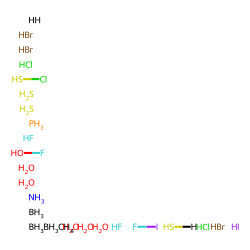

In [177]:
mol

In [178]:
mol = graph_to_molecule((f, e, e_a))

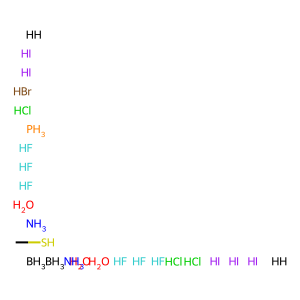

In [81]:
Draw.MolToImage(mol) 

In [203]:
train(g, train_loader=train_loader, valid_loader=val_loader, epochs = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(645.2128, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(678.2071, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(658.9214, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(649.7248, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(638.3267, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(651.7459, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(602.3470, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(647.2584, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(645.8186, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(645.1719, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(677.4279, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(657.5870, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(648.8908, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(637.9448, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(651.9714, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(602.2819, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(647.4409, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(646.0621, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(644.9498, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(677.6658, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(657.5338, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(649.0898, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(637.8239, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(652.1623, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(602.1717, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(647.3228, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(645.7429, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(644.8286, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(677.6309, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(657.4721, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(649.0218, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(637.8447, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(652.0508, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(602.1202, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(647.2677, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(645.7410, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(644.8278, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(677.5989, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(657.4360, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(648.9825, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(637.7856, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(652.0125, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(602.0721, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(647.2221, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(645.6881, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(644.7904, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(677.5634, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(657.3889, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(648.9315, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(637.7448, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(651.9593, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(602.0220, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(647.1712, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(645.6445, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(644.7541, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(677.5198, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(657.3457, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(648.8868, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(637.6986, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(651.9095, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(601.9757, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(647.1249, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(645.5955, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(644.7137, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(677.4777, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(657.3019, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(648.8394, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(637.6503, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(651.8591, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(601.9222, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(647.0716, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(645.5470, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch

In [ ]:
# wykres latent space po logP

In [ ]:
from scipy.stats import entropy
v = [[0.0,1.0],[0.5,0.5]]
w = [0.5]
z = [0.1]

print(entropy(v), entropy(w), entropy(z))

[0.         0.63651417] 0.0 0.0
